In [361]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
from decimal import Decimal
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [362]:
df = pd.read_excel('progetto/ozone.xlsx')

### Introduction

These data record the level of atmospheric ozone concentration from eight daily meteorological measurements made in the Los Angeles basin in 1976.  

Although measurements were made every day that year, some observations were missing; here we have the 330 complete cases.  

The data were given to us by Leo Breiman; he was a consultant on a project from which these data are taken.  

The response, referred to as ozone, is actually the log of the daily maximum of the hourly-average ozone concentrations in Upland, California.

### Variables

ozone : Upland Maximum Ozone

vh : Vandenberg 500 mb Height

wind : Wind Speed (mph)

humidity : Humidity (%)

temp : Sandburg AFB Temperature

ibh : Inversion Base Height

dpg : Daggot Pressure Gradient

ibt : Inversion Base Temperature

vis : Visibility (miles)

doy : Day of the Year

In [363]:
samples, variables = df.shape
print(f'Number of samples: {samples}, number of variables: {variables}')

Number of samples: 330, number of variables: 10


In [364]:
print(f'Quick overview of the Dataframe content:')
df

Quick overview of the Dataframe content:


,ozone,vh,wind,humidity,temp,ibh,dpg,ibt,vis,doy
0,3,5710,4,28,40,2693,-25,87,250,3
1,5,5700,3,37,45,590,-24,128,100,4
2,5,5760,3,51,54,1450,25,139,60,5
3,6,5720,4,69,35,1568,15,121,60,6
4,4,5790,6,19,45,2631,-33,123,100,7
...,...,...,...,...,...,...,...,...,...,...
325,8,5630,4,50,50,2851,-5,100,70,359
326,2,5730,3,53,51,111,-14,225,200,362
327,3,5690,3,23,51,5000,-36,107,70,363
328,5,5650,3,61,50,3704,18,83,40,364


In [396]:
null_values = df.isnull().sum()

print(f"null values: {null_values}")

null values: ozone       0
vh          0
wind        0
humidity    0
temp        0
ibh         0
dpg         0
ibt         0
vis         0
doy         0
dtype: int64


### Data Exploration

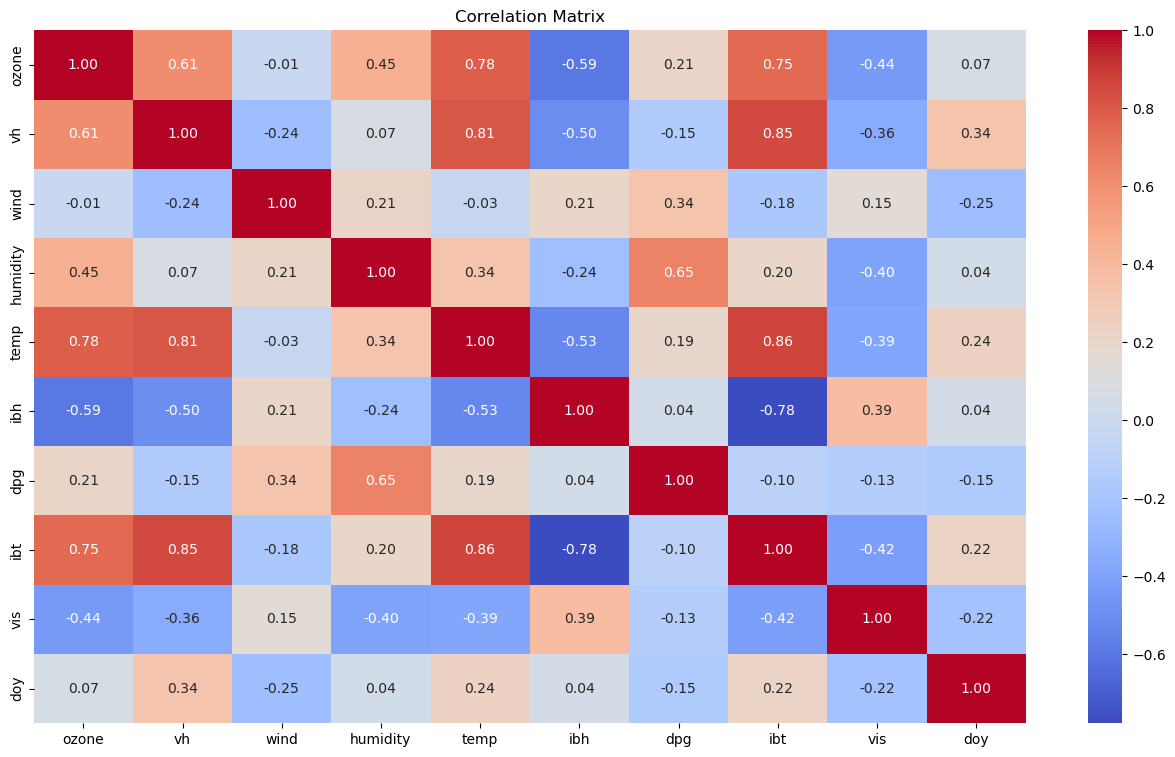

In [392]:
# Assuming you have a DataFrame named 'df'
correlation_matrix = df.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(16, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

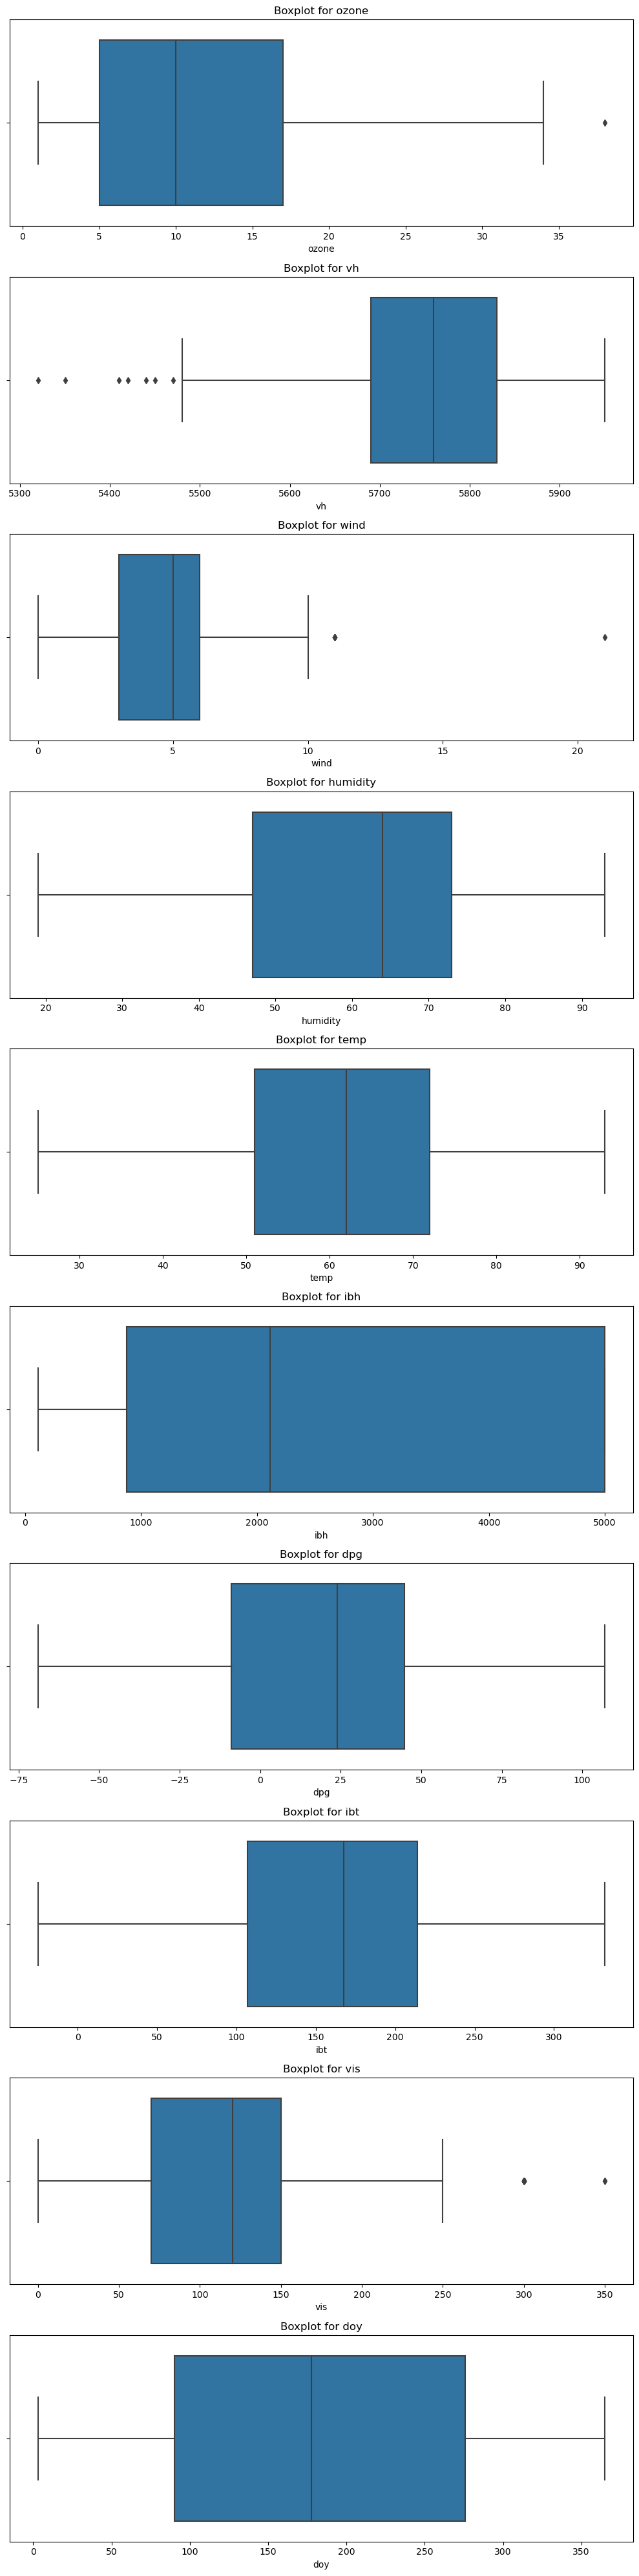

In [365]:
# Get the list of numerical columns in your dataset
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Set up the subplots
fig, axes = plt.subplots(nrows=len(numerical_columns), ncols=1, figsize=(10, 4 * len(numerical_columns)))

# Iterate over each numerical column and create a box plot
for i, column in enumerate(numerical_columns):
    sns.boxplot(x=df[column], ax=axes[i])
    axes[i].set_title(f'Boxplot for {column}')

plt.tight_layout()
plt.show()

### Response exploration (ozone)

In [367]:
target_min, target_max = df["ozone"].min(), df["ozone"].max()

print(f"target variable domain: [ {target_min} ; {target_max} ]")

target variable domain: [ 1 ; 38 ]


In [368]:
target_mean = df["ozone"].mean()

print(f"target variable mean: {target_mean}")

target variable mean: 11.775757575757575


### Response and Regressors definition

In [369]:
y = df['ozone']
X = df.drop('ozone', axis = 1)

## LASSO Regression

In [370]:
# Standardize the features
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Fit LASSO model
lasso = Lasso(alpha = 1.0)
lasso.fit(X_standardized, y)

# Coefficients obtained from LASSO
lasso_coefficients = lasso.coef_

y_pred = lasso.predict(X_standardized)

### Mean Squared Error

In [371]:
mse = mean_squared_error(y, y_pred)
print(f'Mean Square Error: {mse}')

Mean Square Error: 21.787642254667784


### LASSO Coefficients

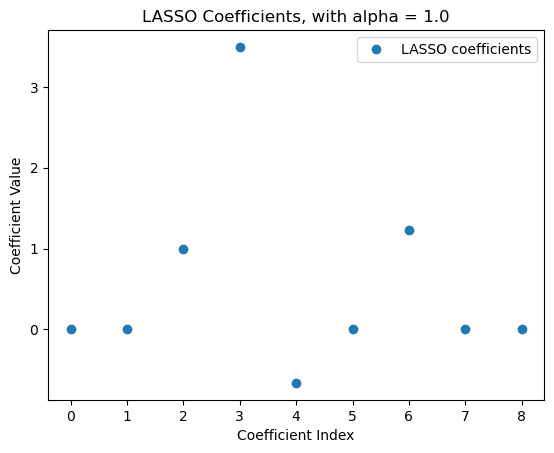

In [372]:
# Visualize the LASSO coefficients
plt.plot(lasso.coef_, marker='o', linestyle='None', label='LASSO coefficients')
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Value')
plt.title(f'LASSO Coefficients, with alpha = {alpha}')
plt.legend()
plt.show()

In [400]:
# Identify selected features (non-zero coefficients)
selected_feature_indices = np.where(lasso_coefficients != 0)[0]

# Map selected feature indices to column names
selected_features = X.columns[selected_feature_indices]

# Print selected features
print("Selected Features:", selected_features)

Selected Features: Index(['humidity', 'temp', 'ibh', 'ibt', 'vis'], dtype='object')


## Analysis of Leverages Points

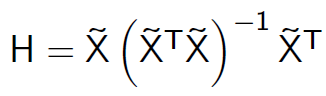

Where:
    
    - X is the standardized matrix of the model

In [373]:
# Calculate hat matrix and leverage points
hat_matrix = np.dot(X_standardized, np.linalg.inv(np.dot(X_standardized.T, X_standardized))).dot(X_standardized.T)
leverage = np.diag(hat_matrix) # hat-values

In [391]:
leverage

array([0.02939903, 0.03102188, 0.02598434, 0.05577916, 0.04681848,
       0.03248932, 0.03498962, 0.02504795, 0.04569718, 0.02308543,
       0.03998817, 0.0391342 , 0.04994804, 0.0731749 , 0.04911528,
       0.02020378, 0.0795854 , 0.04998644, 0.04419898, 0.03114889,
       0.03945994, 0.01492169, 0.03012993, 0.03729408, 0.02597321,
       0.02329911, 0.0358627 , 0.0343204 , 0.03831214, 0.02883129,
       0.04593597, 0.04367998, 0.10776277, 0.06969053, 0.04702261,
       0.06070989, 0.0530366 , 0.0329266 , 0.03068026, 0.03232012,
       0.0264831 , 0.01890704, 0.03042546, 0.03949797, 0.03771559,
       0.03447649, 0.03832468, 0.05857066, 0.0280145 , 0.03357257,
       0.01051483, 0.01460802, 0.02077312, 0.02218234, 0.04378279,
       0.04046735, 0.02964402, 0.08166126, 0.03853787, 0.03261474,
       0.01430661, 0.03089796, 0.03311401, 0.02410358, 0.03064733,
       0.06248625, 0.03508438, 0.01717455, 0.02935883, 0.0180258 ,
       0.02067554, 0.0199154 , 0.04721147, 0.02874857, 0.05076

### Plot of leverages points (hat-values)

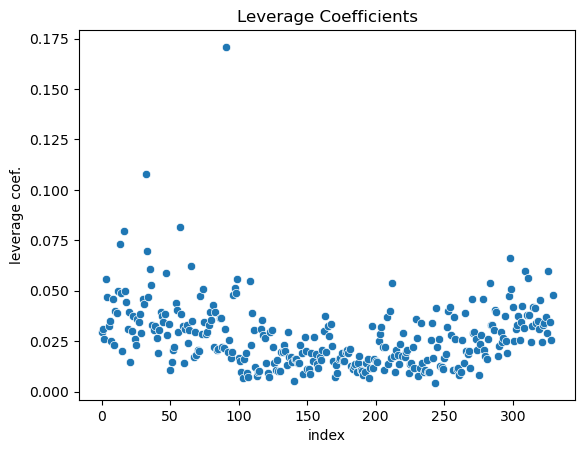

In [374]:
plt.xlabel('index')
plt.ylabel('leverage coef.')
plt.title('Leverage Coefficients')
sns.scatterplot(data = leverage)
plt.show()

### High Leverage Points Identification

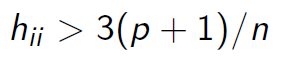

Where:

    - h_ii is the i-th hat value
    - p is the number of variables
    - n is the number of samples

In [435]:
# h_ii > ( 3 * ( p + 1 ) ) / n
# where variables = p, and samples = n
threshold = Decimal( ( 3 * ( variables + 1 ) ) / samples) 
print(f'Leverage threshold value: {threshold}')
high_leverage_points = []

for i, h in enumerate(leverage):    
    if h > threshold:
        print(f'Point-{i} of leverage, value: {h}')
        high_leverage_points.append(i)

Leverage threshold value: 0.1000000000000000055511151231257827021181583404541015625
Point-32 of leverage, value: 0.10776276764538151
Point-91 of leverage, value: 0.17089837757890977


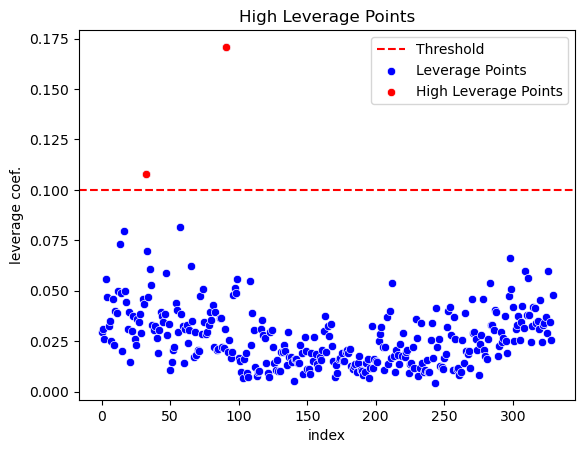

In [436]:
# Create a horizontal line at the threshold
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
leverage_arr = np.array(leverage)
high_leverage_points_arr = np.array(high_leverage_points)

# Scatter plot with high leverage points in red
sns.scatterplot(x=np.arange(len(leverage)), y=leverage, color='blue', label='Leverage Points')

# Highlight high leverage points above the threshold
sns.scatterplot(x=high_leverage_points, y=leverage[high_leverage_points], color='red', label='High Leverage Points')

plt.title('High Leverage Points')
plt.xlabel('index')
plt.ylabel('leverage coef.')
plt.legend()
plt.show()

## Analysis of Cook's Distance

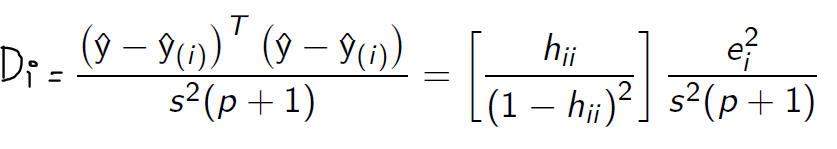

Where:

    - D_i is the i-th Cook's Distance
    - h_ii is the i-th hat values
    - e_i is the i-th residual
    - s**2 is the mean squared error
    - p is the number of variables

### e_i and s**2 calculation

In [376]:
# mean squared error calculation
y_pred = lasso.predict(X_standardized)

mse = mean_squared_error(y, y_pred)
print(f'Mean Squared Error: {mse}')

# residuals e_i calculation
residuals = y - y_pred

Mean Squared Error: 21.787642254667784


### Cook's Distances Calculation

In [426]:
cook_distances = []

for i, h in enumerate(leverage):
    cook_distance = ( h / (1 - h)**2 ) * ( (residuals[i]**2) / (mse * (variables + 1)) )
    cook_distances.append(cook_distance)

In [427]:
cook_distances

[7.692956030508597e-05,
 0.00047707232777388344,
 0.002418690976412906,
 4.811290611431951e-05,
 0.00027398258807719895,
 0.004469411994713469,
 0.0001331526000289103,
 4.375527763910508e-05,
 0.0011479456167248988,
 0.001278045192031375,
 0.002892184182513655,
 0.0012211602840441873,
 0.010369131035415409,
 0.0016246983823183729,
 0.004948014113985603,
 0.0024156549773051037,
 0.023497453023769852,
 0.002805856457665209,
 0.0010158422597960303,
 0.0017575010017947988,
 0.010519235161315699,
 0.0003070667205248864,
 0.0003979093725016356,
 0.00374287809678925,
 0.0028333724260582336,
 4.332935865406282e-05,
 0.0013031429271529356,
 0.003802841666116935,
 0.000748141330094723,
 1.4087540782710927e-08,
 0.0004700186049343282,
 0.0006559947571335917,
 8.566763037455524e-05,
 0.0006165542764087321,
 0.0020626276004007977,
 8.64646010783929e-05,
 5.446491492409285e-05,
 0.00036996010097026206,
 0.00030948357967174864,
 0.003538820305785724,
 4.231447396200253e-06,
 0.00020196874365919015,
 

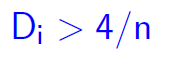

Where:

    - D_i is the i-th Cook's distance
    - n is the number of samples

The point is influential only if the condition is met

In [428]:
print(f"Cook's distance threshold: {(4/samples)}")
influential_points = []

for i, D in enumerate(cook_distances):
    if D > (4/samples):
        print(f"Point {i} is influential according to Cook's distance, D-{i} value: {D}")
        influential_points.append(i)

Cook's distance threshold: 0.012121212121212121
Point 16 is influential according to Cook's distance, D-16 value: 0.023497453023769852
Point 52 is influential according to Cook's distance, D-52 value: 0.01466887390813465
Point 108 is influential according to Cook's distance, D-108 value: 0.014891769496758207
Point 123 is influential according to Cook's distance, D-123 value: 0.021065431510128643
Point 125 is influential according to Cook's distance, D-125 value: 0.014439380718292788
Point 219 is influential according to Cook's distance, D-219 value: 0.018144247406555493
Point 257 is influential according to Cook's distance, D-257 value: 0.01853801076000472
Point 309 is influential according to Cook's distance, D-309 value: 0.01583175803017619
Point 326 is influential according to Cook's distance, D-326 value: 0.02204413040045525


### Plot of Cook's distances

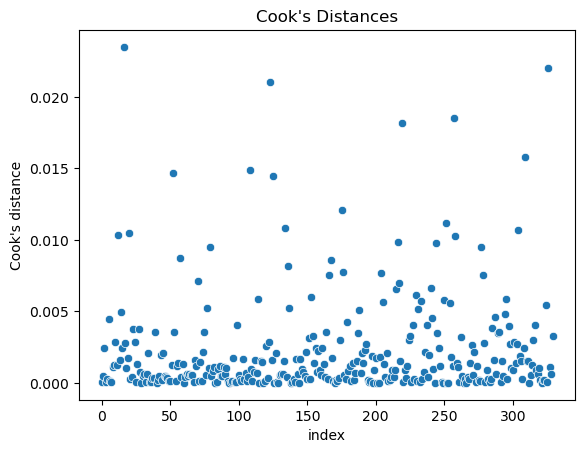

In [429]:
plt.xlabel('index')
plt.ylabel("Cook's distance")
plt.title("Cook's Distances")
sns.scatterplot(data=cook_distances)
plt.show()

In [430]:
influential_points

[16, 52, 108, 123, 125, 219, 257, 309, 326]

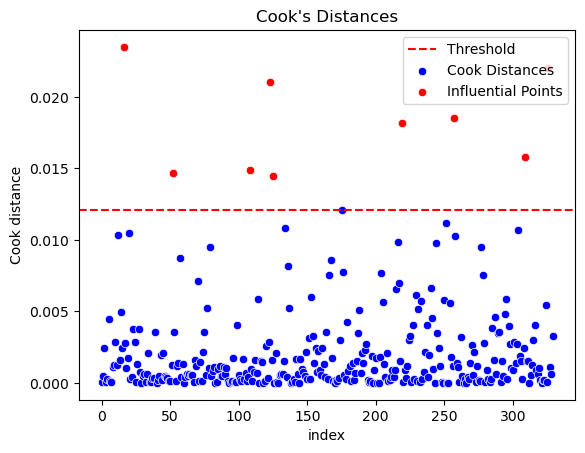

In [437]:
threshold = (4/samples)
influential_points_arr = np.array(influential_points)
cook_distances_arr = np.array(cook_distances)

plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')

sns.scatterplot(x=np.arange(len(cook_distances_arr)), y=cook_distances_arr, color='blue', label='Cook Distances')

sns.scatterplot(x=influential_points_arr, y=cook_distances_arr[influential_points_arr], color='red', label='Influential Points')

plt.title("Cook's Distances")
plt.xlabel('index')
plt.ylabel('Cook distance')
plt.legend()
plt.show()

## Analysis of Difference in Fits (DFFITS)

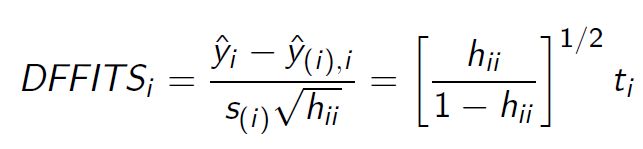

Where:

       - h_ii is the i-th hat value
       - t_i is the i-th studentized residual

### Studentized Residuals

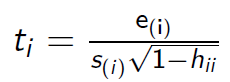

### Residual e(i) (without i-th observation) and Standard Error s(i) (without i-th observation) Definition

In [438]:
y = np.array(y)
e_i = []
s_i = []

In [439]:
for i in range(len(y)):
    # Define a Lasso model withouth the i-th observation
    lasso_without_i = Lasso(alpha = 1.0)
    
    # Define X and y withouth the i-the observation
    X_without_i = np.delete(X_standardized, i, axis=0)
    y_without_i = np.delete(y, i, axis=0) # y_i
    
    # Fit the Lasso model withouth the i-th observation
    lasso_without_i.fit(X_without_i, y_without_i)
    # Prediction on the Lasso model
    y_pred_without_i = lasso_without_i.predict(X_without_i) # y_i(i)
    
    # Definition of residuals without the i-th observation
    residuals_without_i = y_without_i - y_pred_without_i # e(i)
    e_i.append(residuals_without_i[i-1]) # e(i), residuals_without_i has a size of 329
    
    # Definition of standard error withouth the i-th observation
    standard_error = np.std(residuals_without_i)
    s_i.append(standard_error) # s(i)

### DFFITS Calculation

In [440]:
# t_i = e(i) / s(i) * sqrt(1 - h_ii)
DFFITS = []

for i in range(len(y)):
    studentized_residual = e_i[i] / ( s_i[i] * math.sqrt(1 - leverage[i]))
    DFFIT = ( leverage[i] / (1 - leverage[i])**(1/2) ) * studentized_residual
    DFFITS.append(DFFIT)

In [441]:
DFFITS

[-0.02491637041031211,
 -0.005424766331546927,
 -0.011098494367925472,
 -0.05810863136200845,
 0.004373809178393334,
 -0.00877163492956751,
 -0.0430996886020616,
 -0.005025570771287635,
 0.006427688921272926,
 -0.011799149523565278,
 -0.032373888867747724,
 -0.034909181217975524,
 -0.030980795275762748,
 -0.11407224941168626,
 -0.02527324082164399,
 -0.020505553478295673,
 -0.09746128236214509,
 -0.08717024023845862,
 -0.03481266221718509,
 -0.01580515378946244,
 -0.03194544371802205,
 -0.024927009696167415,
 -0.014600665930521095,
 -0.01484255683809649,
 -0.02752806065274008,
 -0.02547254900281761,
 -0.005499465853083332,
 -0.022548725007863212,
 -0.04249429088274945,
 -0.013247212105001977,
 -9.696526604929538e-05,
 -0.014236484094070787,
 0.046843004359060365,
 -0.006566561009816047,
 -0.014925185851652005,
 -0.04287240521100337,
 -0.006665477174302004,
 -0.0031890572030053993,
 0.011001936090310287,
 0.010727054025021814,
 -0.028855516894240117,
 0.000731279990997308,
 -0.010624597

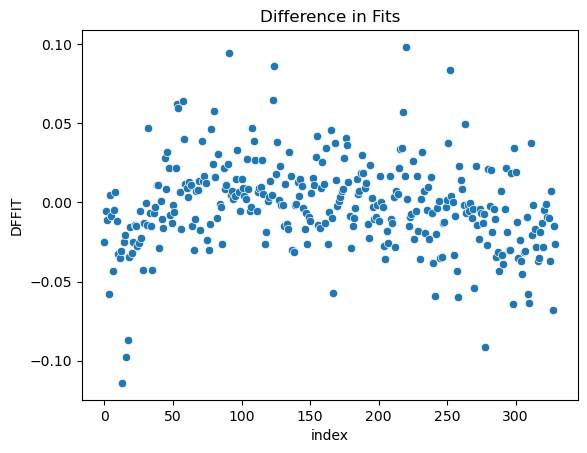

In [442]:
plt.xlabel('index')
plt.ylabel("DFFIT")
plt.title("Difference in Fits")
sns.scatterplot(data=DFFITS)
plt.show()

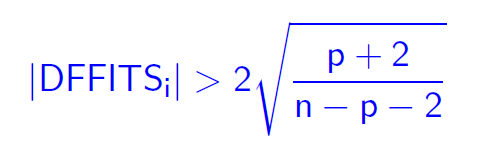

Where

    - DFFITS_i is the i-th Difference in Fit
    - p is the number of variables
    - n is the number of samples

In [443]:
threshold = 2 * math.sqrt( (variables + 2) / (samples - variables - 2) )
print(f'Distance in Fits threshold: {threshold}')
influential_points = []

for i, dffit in enumerate(DFFITS):    
    if abs(dffit) > threshold:
        print(f'Point-{i}, DFFIT: {dffit}')
        influential_points.append(i)

Distance in Fits threshold: 0.38851434494290565


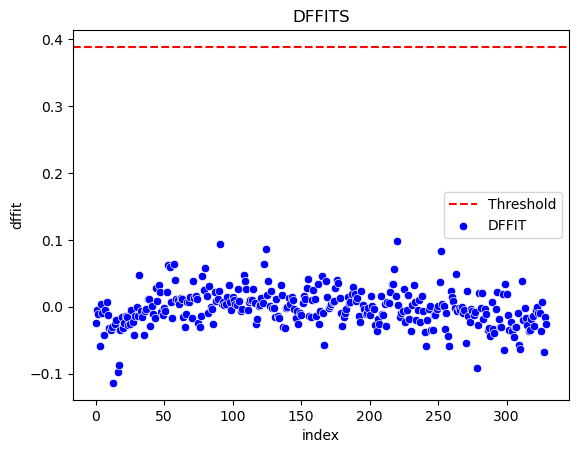

In [445]:
influential_points_arr = np.array(influential_points)
dffits = np.array(DFFITS)

plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')

sns.scatterplot(x=np.arange(len(dffits)), y=dffits, color='blue', label='DFFIT')

#sns.scatterplot(x=influential_points_arr, y=dffits[influential_points_arr], color='red', label='Influential Points')

plt.title("DFFITS")
plt.xlabel('index')
plt.ylabel('dffit')
plt.legend()
plt.show()

### References

Dataset provided by: https://hastie.su.domains/ElemStatLearn/

Lasso model: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html